## Fine-Tuning CLIP Model for Image Classification

### **1. Imports**

In [1]:
import os
import sys

HOME: str = os.getenv('HOME') # echo $HOME
USER: str = os.getenv('USER') # echo $USER
print(f"Current working directory: {os.getcwd()}")
print(f"Initial System path for {USER}: {sys.path}")

# Add the clip directory to the sys.path list
IMACCESS_PROJECT_WORKSPACE = os.path.join(HOME, "WS_Farid", "ImACCESS")
CLIP_DIR = os.path.join(IMACCESS_PROJECT_WORKSPACE, "clip")
print(HOME, USER, IMACCESS_PROJECT_WORKSPACE, CLIP_DIR)
sys.path.insert(0, CLIP_DIR)
print(f"System path for {USER} after inserting customized CLIP: {sys.path}")

import torch
import random
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/farid/WS_Farid/ImACCESS/txt2img/fashion_clip
Initial System path for farid: ['/home/farid/miniconda3/envs/py39/lib/python39.zip', '/home/farid/miniconda3/envs/py39/lib/python3.9', '/home/farid/miniconda3/envs/py39/lib/python3.9/lib-dynload', '', '/home/farid/miniconda3/envs/py39/lib/python3.9/site-packages']
/home/farid farid /home/farid/WS_Farid/ImACCESS /home/farid/WS_Farid/ImACCESS/clip
System path for farid after inserting customized CLIP: ['/home/farid/WS_Farid/ImACCESS/clip', '/home/farid/miniconda3/envs/py39/lib/python39.zip', '/home/farid/miniconda3/envs/py39/lib/python3.9', '/home/farid/miniconda3/envs/py39/lib/python3.9/lib-dynload', '', '/home/farid/miniconda3/envs/py39/lib/python3.9/site-packages']


### **2. Load a Dataset**

To perform fine-tuning, we will use a small image classification dataset. We’ll use the `ceyda/fashion-products-small` dataset which is a collection of fashion products.

In [2]:
from datasets import load_dataset
ds = load_dataset('ceyda/fashion-products-small')

Repo card metadata block was not found. Setting CardData to empty.


Let's take a look at the features inside this dataset:

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image'],
        num_rows: 42700
    })
})

In [4]:
len(ds.get("train"))

42700

We see that we have `filename`, `link`, `id`, `masterCategory`, `gender`, `subCategory` and `image`. Let's print the first example from this dataset to see what these features mean:

In [5]:
idx = random.randint(0, len(ds.get("train")))
# idx = 15970
entry = ds['train'][idx]
entry

{'filename': '8761.jpg',
 'link': 'http://assets.myntassets.com/v1/images/style/properties/013ae8422b9f8eca20e3e801e38ea7d6_images.jpg',
 'id': '8761',
 'masterCategory': 'Apparel',
 'gender': 'Women',
 'subCategory': 'Bottomwear',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>}

Thus, the features of the dataset are as follows:

* `filename`: this is the filename of the image, indicating that the image is stored or identified with this name.
* `link`: this is a URL link to the actual image file, which is hosted online. This link can be used to view or download the image.
* `id`: this is a unique identifier for the image, which can be used to reference this specific item within the dataset.
* `masterCategory`: this indicates the broad category under which this product falls.
* `gender`: this specifies the intended gender for the product, in this case, men's clothing.
* `subCategory`: this is a more specific category within the master category. "Topwear" indicates that the product is an item of clothing worn on the upper body, such as a shirt, t-shirt, or jacket.
* `image`: this is a PIL (Python Imaging Library) image object, which allows for image manipulation and processing. It specifies the image mode (RGB, meaning it has red, green, and blue color channels) and the image size (384 pixels wide by 512 pixels tall).

Cool, let’s look at the image!

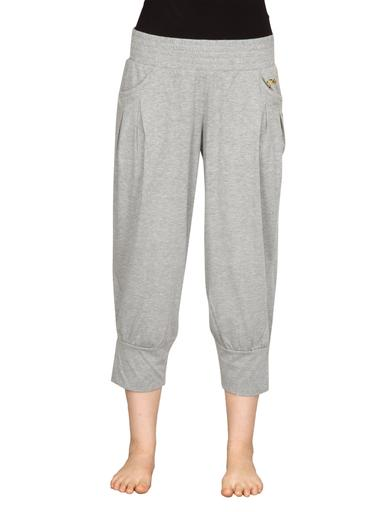

In [6]:
image = entry['image']
image

As expected, it's an item of men's topwear.

We can see that the data itself is comprised of a train dataset, so we will define our dataset as this.

In [7]:
dataset = ds['train']

Awesome, so now we've seen what our dataset looks like, it's time to load our CLIP model and perform preprocessing.

### **3. Load CLIP Model and Preprocessing**

The CLIP model (`ViT-B/32`) and its preprocessing function are loaded. The model is moved to the appropriate device (GPU if available, otherwise CPU).

In [8]:
import clip
model, preprocess = clip.load("ViT-B/32", jit=False) # jit=False for training
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [9]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


Let's take a look at how well our base CLIP model performs image classification on this dataset.

This code uses the CLIP model to classify three example images from our dataset by comparing their visual features with textual descriptions of LABELs. It processes and normalizes the features of the images and subcategory texts, calculates their similarity, and predicts the subcategory for each image. Finally, it visualizes the images alongside their predicted and actual LABELs in a plot.

Topwear                     14737
Shoes                        7316
Bags                         3022
Watches                      2522
Bottomwear                   2453
Innerwear                    1679
Jewellery                    1072
Eyewear                      1044
Fragrance                    1003
Sandal                        958
Flip Flops                    903
Wallets                       893
Belts                         808
Socks                         687
Loungewear and Nightwear      468
Dress                         451
Saree                         426
Headwear                      290
Lips                          267
Ties                          258
Nails                         228
Makeup                        211
Accessories                   136
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    102
Stoles                         89
Skin Care                      77
Skin          

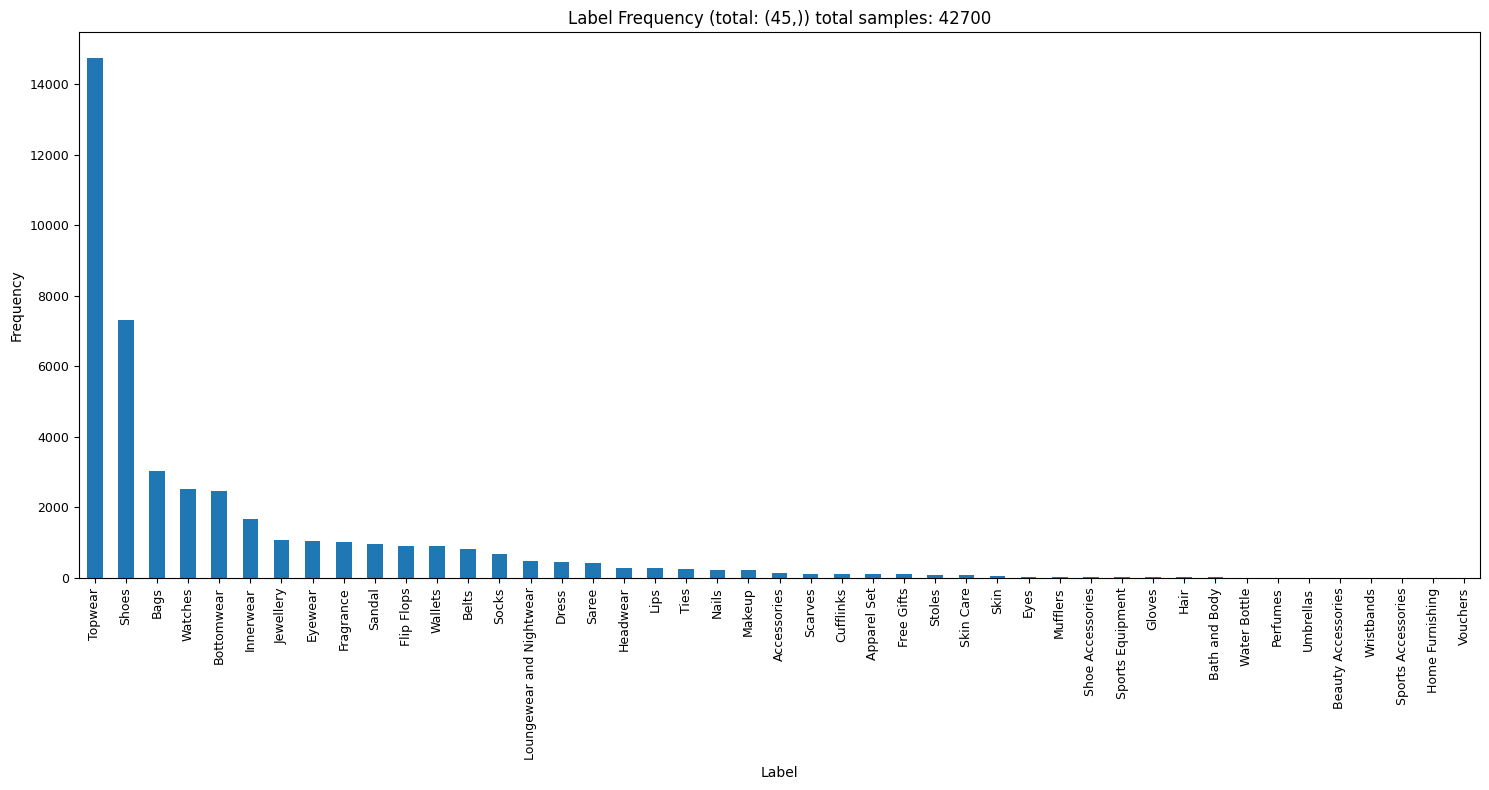

In [10]:
# Convert the 'subCategory' column to a pandas Series
subcategory_series = pd.Series(example['subCategory'] for example in dataset)

# Get the value counts of each subcategory
label_counts = subcategory_series.value_counts()

# Print the result
print(label_counts)

plt.figure(figsize=(15, 8))
label_counts.plot(kind='bar', fontsize=9)
plt.title(f'Label Frequency (total: {label_counts.shape}) total samples: {subcategory_series.shape[0]}')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [11]:
# Get the list of possible LABELs from the dataset
LABELs = list(set(example['subCategory'] for example in dataset))
num_classes = len(LABELs)

# print(num_classes)
# LABELs

In [12]:
# Preprocess the text descriptions for each subcategory
# text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in LABELs]).to(device)
text_inputs = torch.cat([clip.tokenize(texts=c) for c in LABELs]).to(device)
print(type(text_inputs), text_inputs.shape)

<class 'torch.Tensor'> torch.Size([45, 77])


<class 'torch.Tensor'> torch.Size([45, 77])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([77, 45, 512])
<class 'torch.Tensor'> torch.Size([45, 77])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([77, 45, 512])
<class 'torch.Tensor'> torch.Size([45, 77])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([77, 45, 512])
<class 'torch.Tensor'> torch.Size([45, 77])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([77, 45, 512])
<class 'torch.Tensor'> torch.Size([45, 77])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([45, 77, 512])
<class 'torch.Tensor'> torch.Size([77, 45, 512])
<class 'torch.Tensor'> torch.Size([45, 77])
<

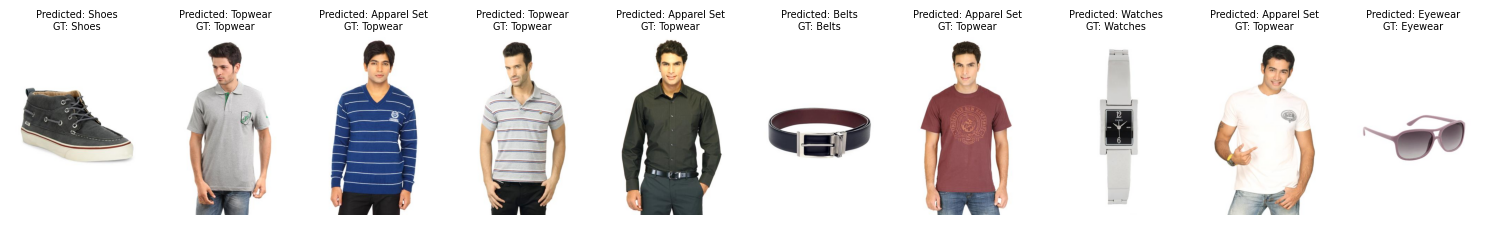

In [13]:

# Select indices for three example images
# indices = [1, 33, 50, 508, 1000]
indices = list(np.random.randint(low=0, high=len(ds.get("train")), size=10, dtype=int))

# Create a figure with subplots
fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
	idx = int(idx)
	# Select an example image from the dataset
	example = dataset[idx]
	image = example['image']
	subcategory = example['subCategory']

	# Preprocess the image
	image_input = preprocess(image).unsqueeze(0).to(device)

	# Calculate image and text features
	with torch.no_grad():
		image_features = model.encode_image(image_input)
		text_features = model.encode_text(text_inputs)

	# Normalize the features
	image_features /= image_features.norm(dim=-1, keepdim=True)
	text_features /= text_features.norm(dim=-1, keepdim=True)

	# Calculate similarity between image and text features
	similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
	probs_vals, probs_idxs = similarity[0].topk(1)

	# Display the image in the subplot
	axes[i].imshow(image)
	axes[i].set_title(f"Predicted: {LABELs[probs_idxs[0]]}\nGT: {subcategory}", fontsize=7)
	axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

As we can see for the three images, our base CLIP model does not perform very well. It only identifies one of the three images correctly.

Let's set up the process for fine-tuning our CLIP model to improve these predictions.

### **4. Processing the Dataset**

First, we must split our dataset into training and validation sets. This step is crucial because it allows us to evaluate the performance of our machine learning model on unseen data, ensuring that the model generalizes well to new, real-world data rather than just the data it was trained on.

We take 80% of the original dataset to train our model and the remaining 20% as the validation data.

In [14]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

Next, we create a custom dataset class:

In [15]:
# Define a custom dataset class
class FashionDataset(Dataset):
	def __init__(self, data):
		self.data = data
		self.transform = transforms.Compose(
			[
				transforms.Resize((224, 224)),
				transforms.ToTensor(),
				transforms.Normalize(
					(0.48145466, 0.4578275, 0.40821073), 
					(0.26862954, 0.26130258, 0.27577711)
				)
			]
		)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, idx):
		item = self.data[idx]
		doc_image = item['image']
		doc_label = item['subCategory']
		doc_image_tensor = self.transform(doc_image)
		doc_label_idx = LABELs.index(doc_label)
		return doc_image_tensor, doc_label_idx # <class 'torch.Tensor'> torch.Size([3, 224, 224]) <class 'int'> 31

Let's break this down:

* **`__init__` method**: Initializes the dataset object with data and sets up a series of transformations to preprocess the images. The transformations include resizing the images to 224x224 pixels, converting them to tensors, and normalizing them with specific mean and standard deviation values.
* **`__len__` method**: Returns the number of samples in the dataset.
* **`__getitem__` method**: Retrieves an image and its corresponding subcategory from the dataset. The image is transformed using the predefined transformations, and the subcategory is converted to a label by finding its index in the LABELs list.

In [16]:
train_dataset, val_dataset = random_split(
  dataset=dataset, 
  lengths=[train_size, val_size],
  generator=torch.Generator().manual_seed(42),
)
print(len(dataset), train_size, val_size)

42700 34160 8540


Next, we create DataLoaders:

In [ ]:
batch_size = 128
# Create DataLoader for training and validation sets
train_loader = DataLoader(
	dataset=FashionDataset(train_dataset), 
	batch_size=batch_size, 
	shuffle=True,
)
val_loader = DataLoader(
	dataset=FashionDataset(val_dataset), 
	batch_size=batch_size,
	shuffle=False,
)
print(len(train_loader), len(val_loader))

1068 267


Here,
* `train_loader`: A DataLoader for the training set, with a batch size of 32 and shuffling enabled to randomize the order of samples.
* `val_loader`: A DataLoader for the validation set, with a batch size of 32 and shuffling disabled to maintain the order of samples.

In [18]:
def visualize_samples(dataloader, num_samples=5):
	for batch_idx, (batch_imgs, batch_lbls) in enumerate(dataloader):
		print(batch_idx, batch_imgs.shape, batch_lbls.shape, len(batch_imgs), len(batch_lbls)) # torch.Size([32, 3, 224, 224]) torch.Size([32])
		if batch_idx >= num_samples:
			break
		
		image = batch_imgs[batch_idx].permute(1, 2, 0).numpy() # Convert tensor to numpy array and permute dimensions
		caption_idx = batch_lbls[batch_idx]
		print(image.shape, caption_idx)
			
		# # Denormalize the image
		image = image * np.array([0.2268645167350769]) + np.array([0.6929051876068115])
		image = np.clip(image, 0, 1)  # Ensure pixel values are in [0, 1] range
		
		plt.figure(figsize=(5, 5))
		plt.imshow(image)
		plt.title(f"Caption: {caption_idx} {LABELs[caption_idx]}")
		plt.axis('off')
		plt.show()

0 torch.Size([32, 3, 224, 224]) torch.Size([32]) 32 32
(224, 224, 3) tensor(2)


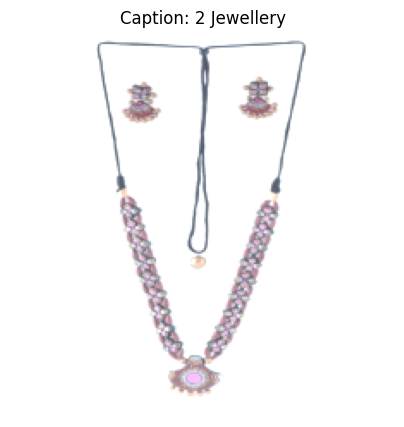

1 torch.Size([32, 3, 224, 224]) torch.Size([32]) 32 32
(224, 224, 3) tensor(19)


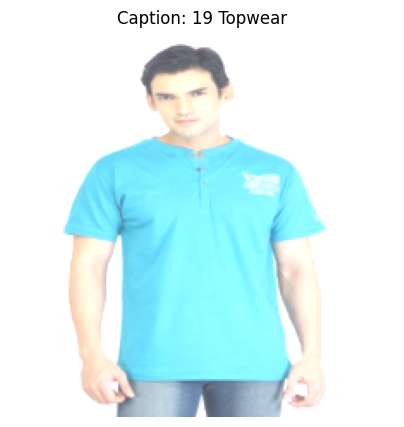

2 torch.Size([32, 3, 224, 224]) torch.Size([32]) 32 32
(224, 224, 3) tensor(8)


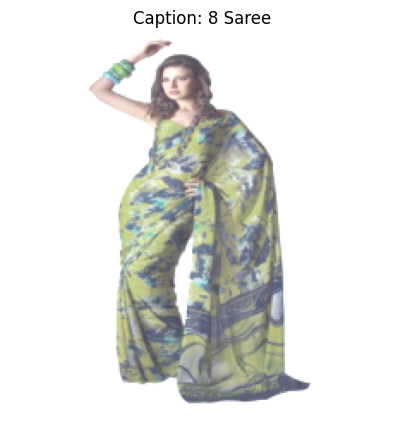

3 torch.Size([32, 3, 224, 224]) torch.Size([32]) 32 32
(224, 224, 3) tensor(19)


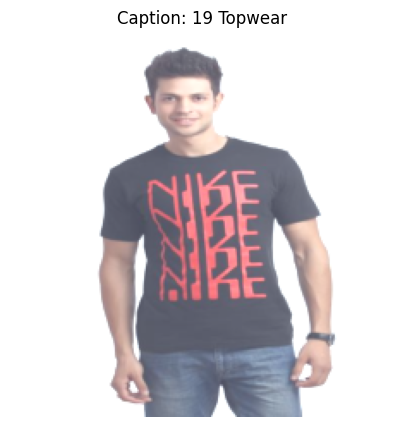

4 torch.Size([32, 3, 224, 224]) torch.Size([32]) 32 32
(224, 224, 3) tensor(19)


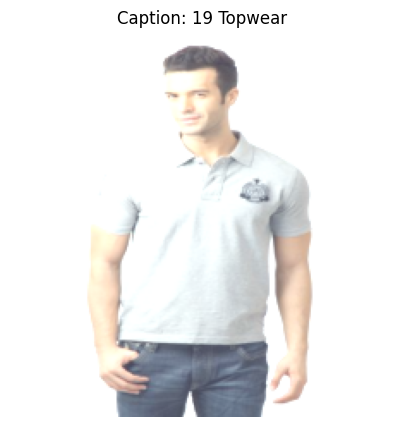

5 torch.Size([32, 3, 224, 224]) torch.Size([32]) 32 32


In [19]:
# visualize_samples(dataloader=train_loader)
visualize_samples(dataloader=val_loader)

In [20]:
t, v = random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
print(len(t), len(v), list(t), list(v))

3 7 [2, 6, 1] [8, 4, 5, 0, 9, 3, 7]


Next, we modify the model for fine-tuning:

In [21]:
# Modify the model to include a classifier for LABELs
class CLIPFineTuner(nn.Module):
	def __init__(self, model, num_classes):
		super(CLIPFineTuner, self).__init__()
		self.model = model
		self.classifier = nn.Linear(model.visual.output_dim, num_classes)

	def forward(self, x):
		with torch.no_grad():
			features = self.model.encode_image(x).float() # Convert to float32
		return self.classifier(features) # predict label

Here,
* **`__init__` method**: Initializes the fine-tuning model with a base CLIP model and a new linear classifier for the LABELs. The linear layer has `num_classes` output units, corresponding to the number of LABELs.
* **`forward` method**: Passes the input images through the base CLIP model to extract features (without updating the base model's weights) and then through the new classifier to predict the subcategory.

Finally, we instantiate the fine-tuning model:

In [22]:
model_ft = CLIPFineTuner(model, num_classes).to(device)

Here,
* `num_classes`: The number of unique LABELs in the dataset.
* `model_ft`: An instance of the `CLIPFineTuner` class, set up for fine-tuning on the subcategory classification task, and moved to the specified device (CPU or GPU).

Amazing! We've set up everything we need to perform fine-tuning! Let's now define our loss function and optimizer.

### **5. Define Loss Function and Optimizer**

We define as follows:

In [23]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
	params=model_ft.classifier.parameters(), 
	lr=1e-4,
)

Here,
* `criterion`: The loss function used is Cross-Entropy Loss, which is suitable for multi-class classification tasks.
* `optimizer`: The optimizer used is Adam, applied only to the parameters of the classifier layer (model_ft.classifier.parameters()) with a learning rate of 0.0001.

Great, now we set up the fine-tuning!

### **6. Fine-Tuning CLIP Model**

We are now in a position to perform our fine-tuning.

Let's break down the code in the training loop:

**Training:**

* `num_epochs`: Specifies the number of epochs (iterations over the entire training dataset).
* Training mode: The model is set to training mode using `model_ft.train()`.
* Progress bar: A progress bar (`tqdm`) is used to track the progress of the training loop, displaying the current epoch and running loss.
* Training steps:
	- For each batch of images and labels from `train_loader`:
		- Move the images and labels to the specified device (CPU or GPU).
		- Zero the gradients using `optimizer.zero_grad()`.
		- Forward pass: Compute the model's outputs.
		- Compute the loss using criterion.
		- Backward pass: Compute gradients using `loss.backward()`.
		- Update the model parameters using `optimizer.step()`.
		- Update the running loss.
		- Update the progress bar description with the average loss for the epoch.
- After each epoch, the average loss for the epoch is printed.

**Validation:**
- Evaluation mode: The model is set to evaluation mode using `model_ft.eval()`.
- Accuracy calculation:
	- Disable gradient computation with `torch.no_grad()`.
	- For each batch of images and labels from val_loader:
		- Move the images and labels to the specified device.
		- Forward pass: Compute the model's outputs.
		- Get the predicted labels by finding the class with the highest score using `torch.max`.
		- Update the total number of labels and the count of correct predictions.
	- Calculate and print the validation accuracy as a percentage.

**Save the Fine-Tuned Model:**
The state dictionary of the fine-tuned model is saved to a file named `'clip_finetuned.pth'`.

In [24]:
# Number of epochs for training
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
		model_ft.train()  # Set the model to training mode
		running_loss = 0.0  # Initialize running loss for the current epoch
		pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

		for images, labels in pbar:
				images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
				optimizer.zero_grad()  # Clear the gradients of all optimized variables
				outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
				loss = criterion(outputs, labels)  # Calculate the loss
				loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
				optimizer.step()  # Perform a single optimization step (parameter update)

				running_loss += loss.item()  # Update running loss
				pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

		print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

		# Validation
		model_ft.eval()  # Set the model to evaluation mode
		correct = 0  # Initialize correct predictions counter
		total = 0  # Initialize total samples counter

		with torch.no_grad():  # Disable gradient calculation for validation
			for images, labels in val_loader:
				images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
				outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
				_, predicted = torch.max(input=outputs.data, dim=1)  # Get the class label with the highest probability
				total += labels.size(0)  # Update total samples
				correct += (predicted==labels).sum().item()  # Update correct predictions

		print(f'Validation Accuracy: {100*correct/total:.3f} %')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), f'fashion_classifier_epochs_{num_epochs}.pth')  # Save the model's state dictionary

Epoch 1/1, Loss: 1.5846: 100%|██████████| 1068/1068 [02:34<00:00,  6.93it/s]


Epoch [1/1], Loss: 1.5846
Validation Accuracy: 84.496 %


### Model Evalauation

In [25]:
def evaluate(model, model_fpth, val_loader):
	# Load the saved model weights
	model.load_state_dict(torch.load(model_fpth, weights_only=True, map_location=device))
	model.eval()  # Set the model to evaluation mode
	correct = 0  # Initialize correct predictions counter
	total = 0  # Initialize total samples counter
	with torch.no_grad():  # Disable gradient calculation for validation
		for images, labels in val_loader:
			images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
			outputs = model(images)  # Forward pass: compute predicted outputs by passing inputs to the model
			_, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
			total += labels.size(0)  # Update total samples
			correct += (predicted == labels).sum().item()  # Update correct predictions
	print(f'Validation Accuracy: {100*correct/total:.3f} %')


In [26]:
evaluate(
  model=model_ft,
  model_fpth=f'fashion_classifier_epochs_{num_epochs}.pth',
  val_loader=val_loader,
)

Validation Accuracy: 84.496 %


Amazing! Let's now take a look at how our new model performs on the same images we tested earlier.

### Zero shot classification

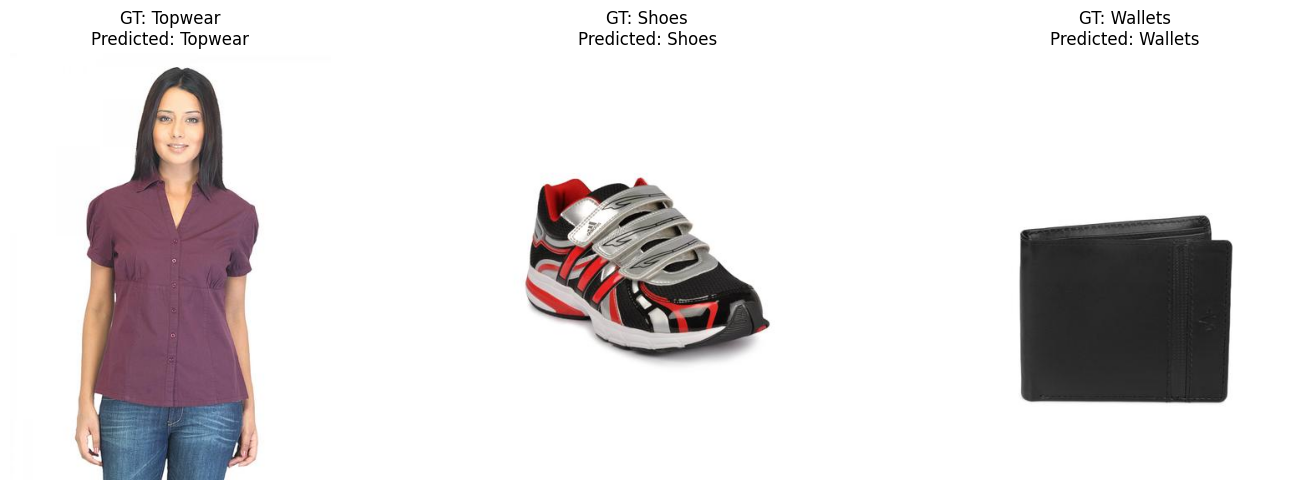

In [27]:

# Define the indices for the three images
# indices = [0, 2, 10]
indices = [7, 120, 105]

# Preprocess the image
transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Create a figure with subplots
fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
	# Get the image and label from the dataset
	item = dataset[idx]
	image = item['image']
	true_label = item['subCategory']

	# Transform the image
	image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

	# Perform inference
	with torch.no_grad():
		output = model_ft(image_tensor)
		_, predicted_label_idx = torch.max(output, 1)
		predicted_label = LABELs[predicted_label_idx.item()]

	# Display the image in the subplot
	axes[i].imshow(image)
	axes[i].set_title(f'GT: {true_label}\nPredicted: {predicted_label}')
	axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

Super cool! Our newly fine-tuned CLIP model successfully predicts the labels for the three images.

Why don't you test out different images and settings to see if you can get even better results!

In [28]:
my_img = Image.open("/home/farid/WS_Farid/ImACCESS/TEST_IMGs/COCO_val2014_000000000536.jpg")
tokenized_text = clip.tokenize(texts=LABELs).to(device)

# Transform the image
image_tensor = transform(my_img).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Perform inference
with torch.no_grad():
	output = model_ft(image_tensor)
	_, predicted_label_idx = torch.max(output, 1)
	predicted_label = LABELs[predicted_label_idx.item()]

print(predicted_label)

Innerwear
